# Clustering

In this notebook, we learn about one of the most common un-supervised learning methods: clustering. There isn't a single algorithm for clustering, but the most common one is called **k-means clustering** where $k$ refers to the number of clusters we wish to have. Note that $k$ isn't really something we can learn from the data. It's something we must specify ahead of time, and while there are some guidelines we can use to choose a reasonable value for $k$, ultimately it's a subjective choice. In fact, with un-supervised learning in general, there is a lot of subjectivity involved, making it hard to interpret results.

In [1]:
import pandas as pd
import numpy as np

census = pd.read_csv('data/adult_train.csv', sep = ",", header = 0)
census = census.drop(columns = ['fnlwgt', 'age'])
census.head()

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


To make some of the results we generate a little easier to read, we will clean the data in the following way:
1. We replace the any hyphen with underscore in the column names.
1. In the `income` column, we replace `<=` with `lt_` and `>` with `gt_`

In [2]:
census.columns = census.columns.str.replace("-", "_")

census["income"] = census["income"].replace("<=", "lt_", regex = True)
census["income"] = census["income"].replace(">", "gt_", regex = True)

census["income"].value_counts()

 lt_50K    24720
 gt_50K     7841
Name: income, dtype: int64

### Exercise

Let's get a list of all the categorical columns in the data:

In [3]:
cat_vars = census.select_dtypes('object').columns.to_list()

For each of the categorical columns in `cat_vars` do the following:

- Find all the rows that hypens and replace it with underscore.
- Convert all the strings to lower case.

In [20]:
for c in cat_vars:
    census[c] = census[c].str.lower().replace("-", "_")
#    census[c] = census[c].str.lower()


Show the top 5 rows of the data to make sure your transformations worked.

In [21]:
census[cat_vars].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,state_gov,bachelors,never_married,adm_clerical,not_in_family,white,male,united_states,lt_50k
1,self_emp_not_inc,bachelors,married_civ_spouse,exec_managerial,husband,white,male,united_states,lt_50k
2,private,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,united_states,lt_50k
3,private,11th,married_civ_spouse,handlers_cleaners,husband,black,male,united_states,lt_50k
4,private,bachelors,married_civ_spouse,prof_specialty,wife,black,female,cuba,lt_50k


### End of exercise

The k-means clustering algorithm tries to find which rows of the data are similar to each other, where similarity is based having attributes (columns) that are close to each other. To determine closeness, we use **Euclidean distance**. Let's say for the sake of example we have only two columns: `education_num` and `capital_gain`. Let's grab two rows of the data (can be any two rows):

In [22]:
which_cols = ['education_num', 'capital_gain']

two_rows = census.loc[[0, 197], which_cols]
two_rows

,education_num,capital_gain
0,13,2174
197,14,14084


The $E_0$ and $C_0$ refer to `education_num` and `capital_gain` at row with index 0, and $E_{197}$ and $C_{197}$ refer to `education_num` and `capital_gain` at row with index 197, the the Euclidean distance between the two rows is given by the following equation: 

$$D(0, 197) = \sqrt{(E_0-E_{197})^2 + (C_0-C_{197})^2}$$

To calculate this distance, it's probably easiest to convert our `DataFrame` to a `numpy` array first:

In [23]:
two_rows = two_rows.values # using values turns DataFrame into numpy array
two_rows

array([[   13,  2174],
       [   14, 14084]])

### Exercise

Use `numpy` to calculate the Euclidean distance between the two rows:

In [24]:
dist = np.linalg.norm(two_rows[0]-two_rows[1])
print(dist)

11910.000041981528


Notice that the Euclidian distance is dominated by the difference in the rows in the `captial_gain` column. This is because this column has a much bigger **scale** than `education_num`. So what can we do to make sure both columns can influence the distance equally? We can **normalize** the columns.

Use `numpy` to normalize the columns of the data. We will use **Z-normalization**, which is the following transformation: 

$$x_{\text{norm}} = \dfrac{x - \text{mean}(x)}{\text{std}(x)}$$

Where the mean and standard deviation are calculated on the **whole data**, not just the two rows above. Find the mean and standard deviations of `education_num` and `capital_gain` for the whole `census` data and use them to normalize the `two_rows`.

HINT: You can calculate the mean using this: `census[which_cols].values.mean(axis = 0)`. By default `axis = 0` but we specify it just to be sure. You can get the standard deviation similarly, using the `std` method.

In [25]:
for col in which_cols:
    col_zscore = col + '_zscore'
    census[col_zscore] = (census[col] - census[col].mean())/census[col].std(ddof=0)

census.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,education_num_zscore,capital_gain_zscore
0,state_gov,bachelors,13,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,lt_50k,1.134739,0.148453
1,self_emp_not_inc,bachelors,13,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,lt_50k,1.134739,-0.145920
2,private,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,lt_50k,-0.420060,-0.145920
3,private,11th,7,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,lt_50k,-1.197459,-0.145920
4,private,bachelors,13,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,lt_50k,1.134739,-0.145920


Calculate the Euclidean distance of the normalized values of `two_rows`.

In [26]:
znorm_cols = ['education_num_zscore', 'capital_gain_zscore']
two_rows = census.loc[[0, 197], znorm_cols]
two_rows = two_rows.values
two_rows

dist = np.linalg.norm(two_rows[0] - two_rows[1])
print(dist)

1.6588715299689416


### End of exercise

If we had more columns we simply add a squared difference for each to the formula, and the `numpy` code to compute the distance stays the same. 

Let's now normalize all our numeric columns in one go using `pandas`. First we get a list of the numeric columns:

In [11]:
num_cols = census.select_dtypes(['integer', 'float']).columns
print(num_cols)

Index(['education_num', 'capital_gain', 'capital_loss', 'hours_per_week',
       'education_num_zscore', 'capital_gain_zscore'],
      dtype='object')


Now we use the `apply` method to apply a function to all the numeric columns at once, using `axis = 0` to say that the function applies across rows. We can either create a function ahead of time and pass it to apply, or in our case since the function is quite simple, we simply create it on the fly using the **lambda notation**. The important thing about our function is that it must be a function of a single array (which represents a column in our data), and return an array of the same size. A Z-normalization function matches this description.

In [12]:
census_rescaled = census[num_cols]
census_rescaled = census_rescaled.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
census_rescaled.head()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_zscore,capital_gain_zscore
0,1.134721,0.148451,-0.216656,-0.035429,1.134721,0.148451
1,1.134721,-0.145918,-0.216656,-2.222119,1.134721,-0.145918
2,-0.420053,-0.145918,-0.216656,-0.035429,-0.420053,-0.145918
3,-1.197440,-0.145918,-0.216656,-0.035429,-1.197440,-0.145918
4,1.134721,-0.145918,-0.216656,-0.035429,1.134721,-0.145918


We can create a scatter plot of the `education_num` and `capital_gain`, which we used to illustrate our previous example.

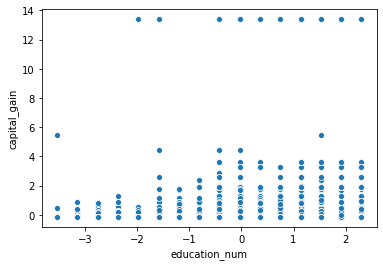

In [13]:
import seaborn as sns

sns.scatterplot(x = 'education_num', y = 'capital_gain', data = census_rescaled);

At first glance, it's seems hard to say if there are more than 2 clusters from looking at the scatter plot above. So should we pick $k=2$ or $k>2$. The answer is that there is no easy answer. $k=2$ might be a safe choice, but has little practical value (so you're telling me that the world is made up of very rich people and everyone else, thanks! I'm so glad I hired a data scientist...). With $k>2$ we can start making more complex differentiation, but it's hard to know where to draw the line and what sets different groups apart. And here we only have two columns and the luxury of looking at scatter plots, but as the number of features goes this becomes a harder and harder problem. Well this is the curse of un-supervised learning!

So for now let's start with $k=2$ and use k-means to cluster the data. We use the `KMeans` function which is the Python's machine learning library `sklearn`. A pattern common to almost all of the ML algorithms in `sklearn` is the following:

1. We initialize the algorithm and specify any arguments if need be. In this case, the number of clusters.
1. We call `fit` and pass it the data. This is when learning happens.
1. We call `transform` and get predictions back. For k-means the predictions are the cluster labels. Any row will be assigned one of $k$ labels, depending on which cluster they belong to.

The above three steps are marked in the code below.

In [49]:
from sklearn.cluster import KMeans
n_clusters = 4 # the number of clusters
which_cols = ['education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

X = census_rescaled#[which_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # step 1: initialize
kmeans.fit(X) # step 2, learn the clusters
census_rescaled['cluster'] = kmeans.predict(X) # step 3, assign a cluster to each row
census_rescaled.head()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_zscore,capital_gain_zscore,cluster
0,1.134721,0.148451,-0.216656,-0.035429,1.134721,0.148451,2
1,1.134721,-0.145918,-0.216656,-2.222119,1.134721,-0.145918,2
2,-0.420053,-0.145918,-0.216656,-0.035429,-0.420053,-0.145918,1
3,-1.197440,-0.145918,-0.216656,-0.035429,-1.197440,-0.145918,1
4,1.134721,-0.145918,-0.216656,-0.035429,1.134721,-0.145918,2


There is one thing to note about k-means. We said in the beginning that k-means is an un-supervised learning algorithm. This means that the data is not labeled ahead of time with clusters that we need to then learn. This means that there is no learning happening, and when we use k-means to assign each row to a cluster, we have no way to **evaluate** the label assignments and determine if we did a good job. This is why we call it **un-supervised**. However, we can still do something that we usually do with **supervised** learning algorithms: we can predict for any new row of data by assigning a cluster to it. How? We simply assign the new row by normalizing it and assigning it whichever cluster **centroid** it is closest (using Euclidean distance to measure closeness). 

Here's how we can find out what the cluster centroids are, but keep in mind that these are centroids based on the **normalized** data, so we have to **un-normalize** it by running the reverse transformation if we want them to be on the same scaled as the original data.

In [50]:
kmeans.cluster_centers_

array([[ 0.35288139, -0.14591824,  4.50268695,  0.23646114,  0.35288139,
        -0.14591824,  1.08221024],
       [-0.52064822, -0.0499627 , -0.21504417,  0.17913111, -0.52064822,
        -0.0499627 ,  0.16448032],
       [ 0.7531013 , -0.08043799, -0.21494519, -0.31800107,  0.7531013 ,
        -0.08043799,  2.81842998],
       [ 1.10294136, 13.39437222, -0.2166562 ,  0.75815674,  1.10294136,
        13.39437222,  2.        ]])

Let's check how the distribution of cluster assignments:

In [51]:
census_rescaled['cluster'].value_counts()

1    18829
2    12089
0     1484
3      159
Name: cluster, dtype: int64

It is very important to note that while the cluster assignments are integers, they have no numeric value, meaning that the numbers are just labels. Cluster 1 is not necessarily closer to cluster 2 than it is to cluster 3. In fact, reruning `KMeans` doesn't guarantee that we will retain the same order. So to be safe, we will convert the `cluster` to `category` type.

In [52]:
census_rescaled['cluster'] = census_rescaled['cluster'].astype('category')

We can redraw our earlier scatter plot and color-code the points by the cluster they belong to.

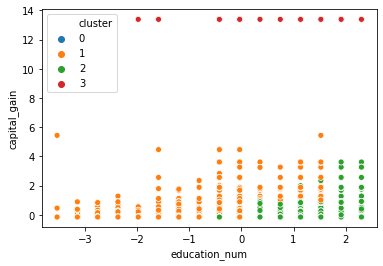

In [53]:
sns.scatterplot(x = 'education_num', y = 'capital_gain', hue = 'cluster', 
                data = census_rescaled);

### Exercise

- Based on the above scatter plot, which of the two features do you think is more important in determining which cluster a person belongs to?
- Return to where we called `KMeans` and change the number of clusters now to $k=3$. Report your findings now: What differentiates cluster 1 form 2, 1 from 3, and 2 from 3?
- Try this again with $k=4$ and report your findings. You can see that as $k$ increases, we have more and more comparisons to make.
- Let's keep $k=4$, but this time instead of passing all four numeric columns to `KMeans`. Do you notice any changes to the scatter plot above?

### End of exercise

- Capital gains looks to be more important, there's less variation
- 

Of course since we added all four numeric columns to `KMeans`, then we have to look at scatter plots of all possible combinations of those four columns: there are $4 \choose 2$ (we read that as **4 choose 2**) which is $\frac{4!}{2!2!} = 6$ possible combinations. There is a very easy way to get all the combinations using the `itertools.combinations` function.

In [54]:
from itertools import combinations
all_pairs = list(combinations(num_cols, 2))

for pair in all_pairs:
    print(pair)

('education_num', 'capital_gain')
('education_num', 'capital_loss')
('education_num', 'hours_per_week')
('education_num', 'education_num_zscore')
('education_num', 'capital_gain_zscore')
('capital_gain', 'capital_loss')
('capital_gain', 'hours_per_week')
('capital_gain', 'education_num_zscore')
('capital_gain', 'capital_gain_zscore')
('capital_loss', 'hours_per_week')
('capital_loss', 'education_num_zscore')
('capital_loss', 'capital_gain_zscore')
('hours_per_week', 'education_num_zscore')
('hours_per_week', 'capital_gain_zscore')
('education_num_zscore', 'capital_gain_zscore')


Let's plot the all the possbile scatter plots form the pairs above.

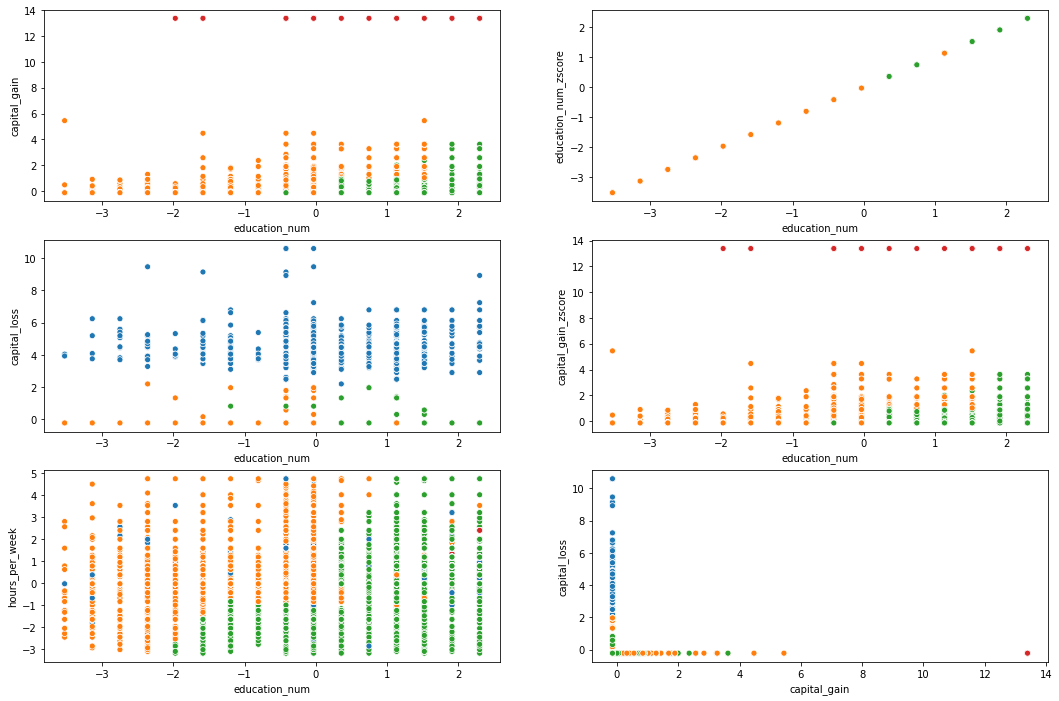

In [55]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 12))
sns.scatterplot(*all_pairs[0], hue = 'cluster', data = census_rescaled, ax = axs[0, 0], legend = False);
sns.scatterplot(*all_pairs[1], hue = 'cluster', data = census_rescaled, ax = axs[1, 0], legend = False);
sns.scatterplot(*all_pairs[2], hue = 'cluster', data = census_rescaled, ax = axs[2, 0], legend = False);
sns.scatterplot(*all_pairs[3], hue = 'cluster', data = census_rescaled, ax = axs[0, 1], legend = False);
sns.scatterplot(*all_pairs[4], hue = 'cluster', data = census_rescaled, ax = axs[1, 1], legend = False);
sns.scatterplot(*all_pairs[5], hue = 'cluster', data = census_rescaled, ax = axs[2, 1], legend = False);

### Exercise

Let's say you are now charged with **profiling** the clusters. That means you need to come up with a brief description of each of the 4 clusters. You can rely on the above scatter plots or any other summaries you like. This is not necessarily an easy task, and the point is to show you the challenge of dealing with un-supervised learning algorithms. Imagine how much harder this would have been with a much larger $k$ or with more features in the data!

In the next notebook, we will use decision trees to help us with this task. Don't worry, there's better ways of doing this than having to look at tons of scatter plots...

### End of exercise

Our clusters so far only used the numeric columns in the data, but we also have a lot of categorical columns and we should be using them too, but we run into a problem: As we saw earlier k-means clustering relies on Euclidean distance to measure the similarity between the rows. So how do you measure Euclidean distance when you have categorical data? The answer is you one-hot encode your categorical data. The quick and easy way to do this is using `pd.get_dummies` function. One-hot encoded (binary) features are also called **dummy variables**, which explains why the function is named `get_dummies`.

In [56]:
census_onehot = pd.get_dummies(census[cat_vars])
census_onehot.head()

,workclass_ ?,workclass_ federal_gov,workclass_ local_gov,workclass_ never_worked,workclass_ private,workclass_ self_emp_inc,workclass_ self_emp_not_inc,workclass_ state_gov,workclass_ without_pay,education_ 10th,...,native_country_ scotland,native_country_ south,native_country_ taiwan,native_country_ thailand,native_country_ trinadad&tobago,native_country_ united_states,native_country_ vietnam,native_country_ yugoslavia,income_ gt_50k,income_ lt_50k
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Let's combine our standardized numeric features and our one-hot-encoded categorical features into one data and train `KMeans` on it.

In [57]:
census_featurized = pd.concat([census_rescaled, census_onehot], axis = 1)

We're going to train with $k=5$ just to use a bigger number.

In [58]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 5

kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(census_featurized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

Instead of adding the clusters as a new column to the featurized data, we add them to the original data. This way we can get summaries on the original (non-normalized) numeric features which makes it easier to interpret results.

In [59]:
census['cluster'] = kmeans.predict(census_featurized)

For example, here's the average of the numeric features grouped by each cluster. It's definitely easier to compare clusters this way than having to look at all those scatter plots.

In [61]:
census.groupby('cluster').mean()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_zscore,capital_gain_zscore
cluster,,,,,,
0,8.579855,648.921237,0.251351,46.287685,-0.583370,-0.058052
1,8.843833,168.264306,0.906376,34.351774,-0.480762,-0.123136
2,12.918239,99999.000000,0.000000,49.798742,1.102958,13.394578
3,10.988544,0.000000,1901.707547,43.357143,0.352887,-0.145920
4,13.118627,1250.455198,0.712094,43.017546,1.180849,0.023399


In addition to comparing averages, it's also important to compare the variability within each cluster. However, if we want to compare variability across features, we need to use standardized features otherwise features on a larger scale will always have more variability.

In [63]:
census_rescaled.groupby('cluster').std()

,education_num,capital_gain,capital_loss,hours_per_week,education_num_zscore,capital_gain_zscore
cluster,,,,,,
0,1.045375,0.000000,0.800684,0.992894,1.045375,0.000000
1,0.743892,0.395940,0.053430,0.774752,0.743892,0.395940
2,0.815306,0.276699,0.051361,1.207842,0.815306,0.276699
3,0.963054,0.000000,0.000000,1.008372,0.963054,0.000000


How do we check how clusters compare across the categories of our categorical variables? One way is to look at two-way tables. We can use `pd.crosstab` for that.

In [71]:
pd.crosstab(census['cluster'], census['workclass'], normalize="all")

workclass,?,federal_gov,local_gov,never_worked,private,self_emp_inc,self_emp_not_inc,state_gov,without_pay
cluster,,,,,,,,,
0,0.009121,0.006726,0.013943,0.000000,0.184116,0.012592,0.033813,0.006726,0.000061
1,0.036424,0.009367,0.017506,0.000215,0.307116,0.004085,0.015816,0.013267,0.000338
2,0.000123,0.000031,0.000184,0.000000,0.002518,0.001106,0.000891,0.000031,0.000000
3,0.001720,0.001720,0.003808,0.000000,0.029391,0.002580,0.004637,0.001720,0.000000
4,0.008998,0.011640,0.028838,0.000000,0.173889,0.013912,0.022880,0.018120,0.000031


### Exercise

- How can we make the above information more useful. We can turn the counts into percentages by cluster. Find how you can use the `normalize` argument, to turn the counts into percentages. Note that `normalize` here has nothing to do with Z-normalization we learned earlier.

- Even more useful would be to display the above table with the percentages as a **heat map**, so that we can quickly compare the distribution of the clusters across different occupations. Turn the above table into a heat map using `seaborn`.

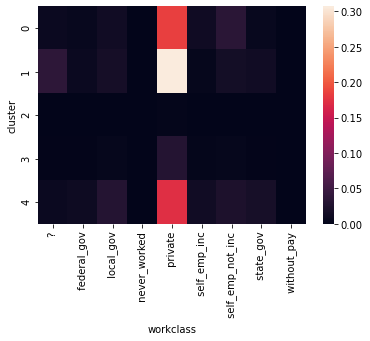

In [72]:
sns.heatmap(pd.crosstab(census['cluster'], census['workclass'], normalize="all"))

- Does anything particularly stand out? Can you refine your profile of each of the clusters based on what you see? It might help to also try other categorical features like `education`, `marital_status`, or `income`.

### End of exercise

There's so much more to say about clustering. Here are two examples:

- We could try to solve the problem of clustering when we have categorical data by defining a distance function that works for categorical data. 
- We could try to find a way to cluster the data **hierarchically**, so that we depend less on a specific choice of $k$. Instead we narrow our choice later by choosing the level of hierarchy we want to stop at. 

The topic of clustering can be its own course!

# Hierarchical Agglomerative clustering

From here: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

In [73]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


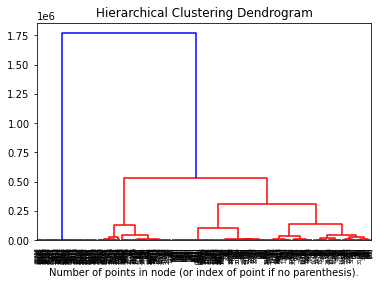

In [77]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

num_cols = census.select_dtypes('integer').columns.to_list()
census_hier = census[num_cols]

model = model.fit(census_hier)
plt.title('Hierarchical Clustering Dendrogram')

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()